In [4]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from src import utils


# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

%matplotlib inline

In [2]:
raw = pd.read_csv('./data/raw_tr_financial_churn.csv')
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6396,15707918,Bentley,741,Germany,Female,36,0,127675.39,2,1,0,74260.16,0
1,6055,15773013,Uvarov,633,France,Female,47,0,0.00,1,1,1,6342.84,1
2,8866,15639004,Chiemezie,668,France,Male,72,2,0.00,2,1,1,70783.61,0
3,9098,15606901,Graham,728,France,Male,43,7,0.00,2,1,0,40023.70,0
4,3865,15808960,Alleyne,620,Germany,Male,40,5,108197.11,2,1,0,49722.34,0


In [17]:
data = raw[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']].copy()

In [18]:
data.Exited.value_counts()

0    5952
1    1548
Name: Exited, dtype: int64

In [19]:
data['Gender'] = data['Gender'].map(lambda e: 0 if e =='Female' else 1)

In [20]:
pd.get_dummies(data['Geography']).head()

,France,Germany,Spain
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0


In [21]:
data = pd.concat([data, pd.get_dummies(data['Geography'])], axis=1)
del data['Geography']
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,741,0,36,0,127675.39,2,1,0,74260.16,0,0,1,0
1,633,0,47,0,0.00,1,1,1,6342.84,1,1,0,0
2,668,1,72,2,0.00,2,1,1,70783.61,0,1,0,0
3,728,1,43,7,0.00,2,1,0,40023.70,0,1,0,0
4,620,1,40,5,108197.11,2,1,0,49722.34,0,0,1,0


##  Base Feature Engineering

In [ ]:
raw = pd.read_csv('./data/raw_tr_financial_churn.csv')
raw.head()

In [12]:
def basic_feature_engineer(raw, is_train=True, sc=None):
    data = raw[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']].copy()
    data['Gender'] = data['Gender'].map(lambda e: 0 if e =='Female' else 1)
    data = pd.concat([data, pd.get_dummies(data['Geography'])], axis=1)
    del data['Geography']
    
    # Split features, label
    data_x, y = data.drop('Exited', 1), data.pop('Exited')
    columns = data_x.columns
    if is_train:
        sc = StandardScaler()
        data_x = pd.DataFrame(data=sc.fit_transform(data_x), columns=columns)
    else:
        data_x = pd.DataFrame(data=sc.transform(data_x), columns=columns)
    return data_x, y, sc
    
tr_x, tr_y, scaler = basic_feature_engineer(raw, True)

In [11]:
tr_x.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
0,0.931808,-1.096651,-0.286140,-1.726890,0.818951,0.804202,0.648425,-1.032253,-0.449945,-1.001601,1.716790,-0.570986
1,-0.185926,-1.096651,0.761549,-1.726890,-1.223103,-0.913689,0.648425,0.968755,-1.631281,0.998401,-0.582482,-0.570986
2,0.176303,0.911867,3.142658,-1.036539,-1.223103,0.804202,0.648425,0.968755,-0.510415,0.998401,-0.582482,-0.570986
3,0.797266,0.911867,0.380571,0.689338,-1.223103,0.804202,0.648425,-1.032253,-1.045445,0.998401,-0.582482,-0.570986
4,-0.320468,0.911867,0.094838,-0.001013,0.507413,0.804202,0.648425,-1.032253,-0.876750,-1.001601,1.716790,-0.570986


In [16]:
# x_tr, x_vl, y_tr, y_vl = \
# train_test_split(data.drop('Exited', 1).values, data.Exited.values[:, None], test_size = 0.2, random_state = 0)
raw_vl = pd.read_csv('./data/raw_vl_financial_churn.csv')

vl_x, vl_y, _ = basic_feature_engineer(raw_vl, is_train=False, sc=scaler)

In [17]:
import keras

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [20]:
K.clear_session()

model = Sequential()
model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 5s 695us/step - loss: 0.4925 - acc: 0.7932 - val_loss: 0.4141 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 3s 341us/step - loss: 0.4375 - acc: 0.7936 - val_loss: 0.4056 - val_acc: 0.8044
Epoch 3/30
7500/7500 [==============================] - 2s 319us/step - loss: 0.4317 - a

In [21]:
def plot_result(hist):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['acc'], label='acc')
    plt.plot(hist.history['val_acc'], label='val_acc')
    plt.title('Accuracy')

    plt.legend(loc='best')
    plt.show()
    

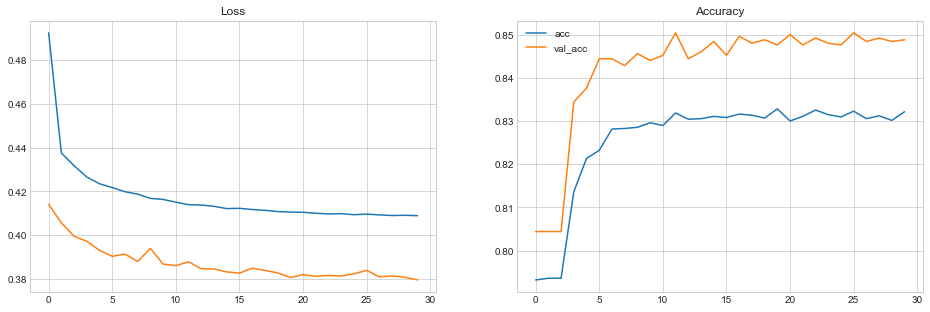

In [22]:
plot_result(hist)

<br/>
<br/>
<br/>

## Feature Engineering

In [5]:
raw = pd.read_csv('./data/raw_tr_financial_churn.csv')
raw_vl = pd.read_csv('./data/raw_vl_financial_churn.csv')
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6396,15707918,Bentley,741,Germany,Female,36,0,127675.39,2,1,0,74260.16,0
1,6055,15773013,Uvarov,633,France,Female,47,0,0.00,1,1,1,6342.84,1
2,8866,15639004,Chiemezie,668,France,Male,72,2,0.00,2,1,1,70783.61,0
3,9098,15606901,Graham,728,France,Male,43,7,0.00,2,1,0,40023.70,0
4,3865,15808960,Alleyne,620,Germany,Male,40,5,108197.11,2,1,0,49722.34,0


In [30]:
def feature_engineer_sqare_sqrt(raw, is_train=True, sc=None):
    data = raw[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']].copy()
    data['Gender'] = data['Gender'].map(lambda e: 0 if e =='Female' else 1)
    data = pd.concat([data, pd.get_dummies(data['Geography'])], axis=1)
    del data['Geography']
    
    # Split features, label
    data_x, y = data.drop('Exited', 1), data.pop('Exited')
    columns = data_x.columns
    if is_train:
        sc = StandardScaler()
        data_x = pd.DataFrame(data=sc.fit_transform(data_x), columns=columns)
    else:
        data_x = pd.DataFrame(data=sc.transform(data_x), columns=columns)
        
    for num_col in ('CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'):
        data_x[f'Square{num_col}'] = data_x[num_col] ** 2
        data_x[f'Sqrt{num_col}'] = data_x[num_col] ** 2
        
    return data_x, y, sc
    # return data

tr_x, tr_y, sc = feature_engineer_sqare_sqrt(raw, is_train=True)
vl_x, vl_y, _ = feature_engineer_sqare_sqrt(raw_vl, is_train=False, sc=sc)

In [34]:
tr_x.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,...,SquareAge,SqrtAge,SquareTenure,SqrtTenure,SquareBalance,SqrtBalance,SquareNumOfProducts,SqrtNumOfProducts,SquareEstimatedSalary,SqrtEstimatedSalary
0,0.931808,-1.096651,-0.286140,-1.726890,0.818951,0.804202,0.648425,-1.032253,-0.449945,-1.001601,...,0.081876,0.081876,2.982148,2.982148,0.670681,0.670681,0.646741,0.646741,0.202451,0.202451
1,-0.185926,-1.096651,0.761549,-1.726890,-1.223103,-0.913689,0.648425,0.968755,-1.631281,0.998401,...,0.579956,0.579956,2.982148,2.982148,1.495981,1.495981,0.834827,0.834827,2.661079,2.661079
2,0.176303,0.911867,3.142658,-1.036539,-1.223103,0.804202,0.648425,0.968755,-0.510415,0.998401,...,9.876301,9.876301,1.074413,1.074413,1.495981,1.495981,0.646741,0.646741,0.260524,0.260524
3,0.797266,0.911867,0.380571,0.689338,-1.223103,0.804202,0.648425,-1.032253,-1.045445,0.998401,...,0.144834,0.144834,0.475187,0.475187,1.495981,1.495981,0.646741,0.646741,1.092956,1.092956
4,-0.320468,0.911867,0.094838,-0.001013,0.507413,0.804202,0.648425,-1.032253,-0.876750,-1.001601,...,0.008994,0.008994,0.000001,0.000001,0.257468,0.257468,0.646741,0.646741,0.768690,0.768690


In [32]:
tr_x.shape, vl_x.shape

((7500, 24), (2500, 24))

In [36]:
K.clear_session()

model = Sequential()
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 24))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 3s 459us/step - loss: 0.4421 - acc: 0.8172 - val_loss: 0.3482 - val_acc: 0.8620
Epoch 2/30
7500/7500 [==============================] - 3s 361us/step - loss: 0.3573 - a

## 加入Dropout

In [41]:
from keras.layers import Dropout

K.clear_session()

model = Sequential()
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 24))
model.add(Dropout(.3))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total para

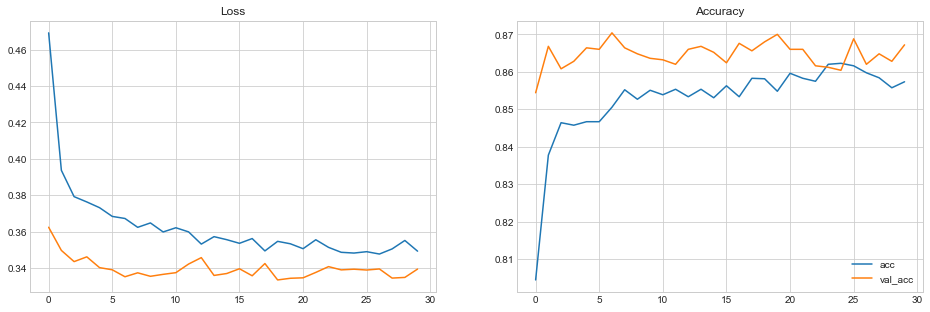

In [42]:
plot_result(hist)

## Batch BatchNormalization, Befoe Activation

In [45]:
from keras.layers import Dropout, BatchNormalization, Activation

K.clear_session()

model = Sequential()
model.add(Dense(units = 32, input_dim = 24))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(units = 16))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(units = 8))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(units = 1, activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
__________

KeyboardInterrupt: 

In [ ]:
plot_result(hist)

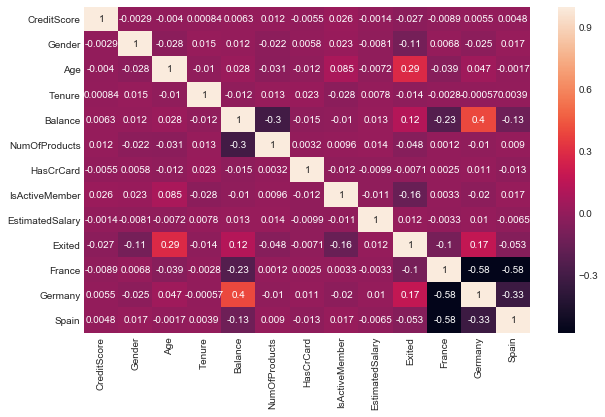

In [62]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True)
plt.show()